# ALeRCE API interaction examples

Load libraries

In [1]:
import sys
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

In [2]:
#!pip install alerce
from alerce.api import AlerceAPI

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20ZTF%20DB%20API.md

In [3]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

# Initialize alerce api object

In [4]:
alerce = AlerceAPI()

# Classifier taxonomy and numeric mappings

There are two classifiers used in ALeRCE, an early classifier and a late classifier. Each one has its own numeric mappings for the different classes. You can use their string or integer names.

The early classifier uses as input the first detection stamps and contains the following classes (numeric mapping shown between parenthesis):

    agn (18)
    sn (19)
    vs (20)
    asteroid (21)
    bogus (22)
    
The late classifier uses the light curve information and contains the following classes (numeric mapping between parenthesis):

    sn ia (10)
    sn ibc (11)
    sn ii (12)
    sn iin (13)
    slsn (14)
    eb/sd/d (15)
    eb/c (16)
    periodic/other (17)
    cv (9)
    nova (9)
    cv/nova (9)
    blazar (8)
    agn i (7)
    dsct (2)
    ceph (0)
    lpv (4)
    rrl (5)

# 1. query

Query a list of objects

The following json file should be sent

```js
{
total: number, // (if not set the total is counted and the query is slower),
records_per_pages: number. // default 20
page: number (default 1),
sortBy: string columnName, // default nobs
query_parameters:{
    filters:{
        //ZTF Object id
        oid: "ZTFXXXXXX",
        //Number of detections
        nobs: { 
            min: int
            max: int
        },
        //Late Classifier (Random Forest)
        classrf: int,
        pclassrf: float [0-1],
        //Early Classifier (Stamp Classifier)
        classearly: int,
        pclassearly: float [0-1],
    },
    //Coordinate based search (RA,DEC) and Search Radius.
    coordinates:{
        ra: float degrees,
        dec: float degrees,
        sr: float degrees
    },
    dates:{
        //First detection (Discovery date)
        firstmjd: {
         min: float mjd,
         max: float mjd
        }
    }
}
```

### Example: 

Give me all the objects with probability of being SNe greater than 0.8 according to the random forest classifier (light curve based), which have between 2 and 40 detections. Give me the second page, with pages of 10 elements each, of a total of at most 40 objects query result.

Note: probabilities are experimental and should not be fully trusted

In [5]:
total = 40
records_per_page = 10
page = 2
sortBy = "firstmjd"
nobsmin = 10
nobsmax = 40
classrf = "sn ia"
pclassrf = 0.3

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": { 
                "min": nobsmin,
                "max": nobsmax
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [6]:
query_results = alerce.query(params)
query_results.head()

,nobs,mean_magap_g,mean_magap_r,median_magap_g,median_magap_r,max_magap_g,max_magap_r,min_magap_g,min_magap_r,sigma_magap_g,...,deltajd,lastmjd,firstmjd,period,catalogid,classxmatch,classrf,pclassrf,pclassearly,classearly
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abjkouf,10,19.777850,19.542616,19.767750,19.466149,20.184299,20.142700,19.391600,19.095699,0.343154,...,6.974803,58700.298773,58693.323970,None,None,None,10,0.308,NaN,NaN
ZTF19ablfdwt,19,19.408025,18.788273,19.364750,18.466499,20.648600,19.589199,18.528700,18.153400,0.845471,...,61.839120,58757.273206,58695.434086,None,None,None,10,0.370,1.000000,19.0
ZTF19abmolyr,39,18.671295,17.995460,18.973900,18.047800,19.804899,18.578501,17.059500,17.007299,0.881335,...,53.723993,58754.200625,58700.476632,None,None,None,10,0.318,1.000000,19.0
ZTF19abplfxs,25,18.749923,18.523442,18.655899,18.413700,20.279499,19.918800,17.742201,17.851999,0.876704,...,48.922130,58756.419826,58707.497697,None,None,None,10,0.304,0.999992,19.0
ZTF19abplzzk,29,19.555484,19.503094,19.639999,19.542951,20.254999,20.250799,18.610600,18.480600,0.451623,...,22.062072,58730.273218,58708.211146,None,None,None,10,0.310,0.950703,21.0


### Example: 

Give me the last 100 objects with classified as SNe according to the early classifier (one image stamp)

Note: this is experimental, about 90% of the candidates are false positives

In [7]:
mjd_48hr = Time(datetime.utcnow(), scale='utc').mjd - 2.

total = 100
records_per_page = 100
sortBy = "pclassearly"

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "classearly": 20  # class 20 is SN by the early classifier
        },
        "dates": {
            "firstmjd": {
                "min": mjd_48hr
            }
        }
    }
}

In [8]:
query_results = alerce.query(params)
query_results.head()

,nobs,mean_magap_g,mean_magap_r,median_magap_g,median_magap_r,max_magap_g,max_magap_r,min_magap_g,min_magap_r,sigma_magap_g,...,deltajd,lastmjd,firstmjd,period,catalogid,classxmatch,classrf,pclassrf,pclassearly,classearly
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abnarqo,1,13.831394,NaN,13.831394,NaN,13.831394,NaN,13.831394,NaN,None,...,0.0,58757.138137,58757.138137,None,None,None,None,None,0.997313,20
ZTF18abvllgh,1,17.392500,NaN,17.392500,NaN,17.392500,NaN,17.392500,NaN,None,...,0.0,58756.412396,58756.412396,None,None,None,None,None,0.997841,20
ZTF18accnkjt,1,13.568093,NaN,13.568093,NaN,13.568093,NaN,13.568093,NaN,None,...,0.0,58756.471759,58756.471759,None,None,None,None,None,0.996821,20
ZTF18ackrrpf,1,NaN,14.540800,NaN,14.540800,NaN,14.540800,NaN,14.540800,None,...,0.0,58757.505174,58757.505174,None,None,None,None,None,0.997351,20
ZTF18aclxwdk,1,NaN,14.185602,NaN,14.185602,NaN,14.185602,NaN,14.185602,None,...,0.0,58757.289143,58757.289143,None,None,None,None,None,0.998133,20


(20.250571248697693, 12.00656045609866)

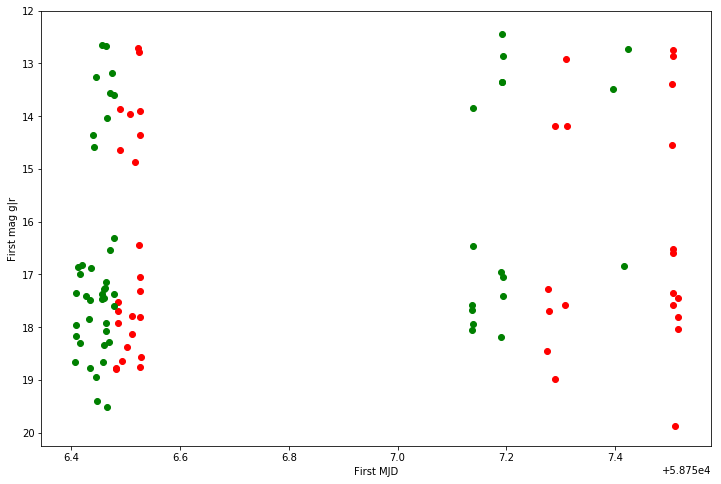

In [9]:
# Show first mag vs first MJD
fig, ax = plt.subplots(figsize = (12, 8))
mask = query_results.first_magpsf_r.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_r[mask], c = 'r')
mask = query_results.first_magpsf_g.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_g[mask], c = 'g')
ax.set_xlabel("First MJD")
ax.set_ylabel("First mag g|r")
ax.set_ylim(ax.get_ylim()[::-1])

You can see the ZTF filter changes during the night. The missing times are due to the ZTF private stream.

# 2. get_sql

Get the sql query using the same parameters as the previous query

In [10]:
alerce.get_sql(params)

b'SELECT * FROM objects WHERE classearly=20 AND  firstmjd >= 58756.08130077192  AND  firstmjd IS NOT NULL '

# 3. get_detections

Get all the detections for an object

In [11]:
oid = "ZTF19abueupg"

In [12]:
detections = alerce.get_detections(oid)
display(detections.head())
list(detections)

,candid_str,oid,mjd,fid,diffmaglim,magpsf,magap,sigmapsf,sigmagap,ra,...,sgscore1,field,rcid,magnr,sigmagnr,rb,magpsf_corr,magap_corr,sigmapsf_corr,sigmagap_corr
candid,,,,,,,,,,,,,,,,,,,,,
970313001115015006,970313001115015006,ZTF19abueupg,58724.313009,1,20.446541,19.588678,19.706900,0.139590,0.1900,267.803262,...,0.5,797,11,20.913000,0.085,0.920000,19.588678,19.706900,0.139590,0.1900
971263501115015039,971263501115015039,ZTF19abueupg,58725.263507,2,20.572720,19.428419,19.548800,0.155431,0.1692,267.803315,...,0.5,797,11,19.693001,0.130,0.592857,19.428419,19.548800,0.155431,0.1692
971289301115015006,971289301115015006,ZTF19abueupg,58725.289306,1,20.407963,19.242842,19.450300,0.099974,0.1279,267.803266,...,0.5,797,11,20.913000,0.085,0.877143,19.242842,19.450300,0.099974,0.1279
972264951115015027,972264951115015027,ZTF19abueupg,58726.264954,2,20.445602,19.110739,18.945101,0.093884,0.1063,267.803325,...,0.5,797,11,19.693001,0.130,0.934286,19.110739,18.945101,0.093884,0.1063
972290601115015008,972290601115015008,ZTF19abueupg,58726.290602,1,20.350231,18.965689,19.068300,0.096079,0.1081,267.803301,...,0.5,797,11,20.913000,0.085,0.951429,18.965689,19.068300,0.096079,0.1081


['candid_str',
 'oid',
 'mjd',
 'fid',
 'diffmaglim',
 'magpsf',
 'magap',
 'sigmapsf',
 'sigmagap',
 'ra',
 'dec',
 'sigmara',
 'sigmadec',
 'isdiffpos',
 'distpsnr1',
 'sgscore1',
 'field',
 'rcid',
 'magnr',
 'sigmagnr',
 'rb',
 'magpsf_corr',
 'magap_corr',
 'sigmapsf_corr',
 'sigmagap_corr']

# 4. get_non_detections

In [13]:
non_detections = alerce.get_non_detections(oid)
non_detections.head()

,oid,diffmaglim,fid
mjd,,,
58695.278808,ZTF19abueupg,18.942801,2
58695.308171,ZTF19abueupg,20.085800,1
58696.280255,ZTF19abueupg,20.712299,2
58696.309468,ZTF19abueupg,20.865499,1
58697.302245,ZTF19abueupg,20.648100,2


(21.114561476191714, 15.778838716069085)

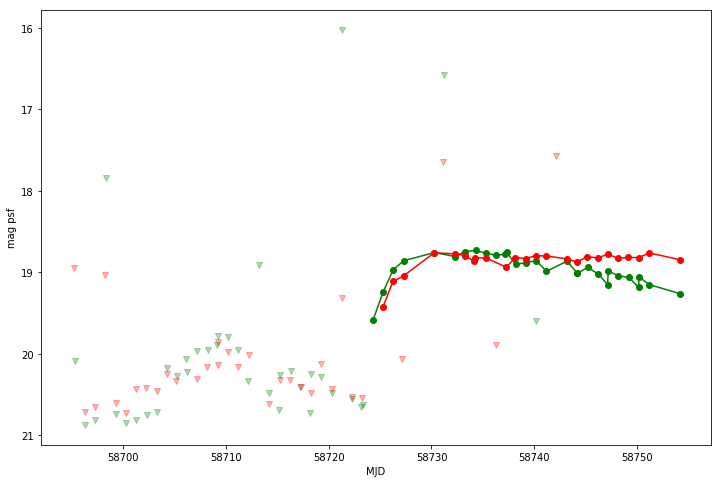

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = ["g", "r"]
for fid in [1, 2]:
    mask = detections.fid == fid
    ax.plot(detections.mjd[mask], detections.magpsf[mask], c = colors[fid - 1], marker = "o")
    mask = non_detections.fid == fid
    # note that the index of non-detectionsis the mjd
    ax.scatter(non_detections.index[mask], non_detections.diffmaglim[mask], c = colors[fid - 1], marker = "v", alpha=0.3)
ax.set_xlabel("MJD")
ax.set_ylabel("mag psf")
ax.set_ylim(ax.get_ylim()[::-1])

# 5. get_stats

In [15]:
stats = alerce.get_stats(oid)
display(stats)
list(stats)

,nobs,mean_magap_g,mean_magap_r,median_magap_g,median_magap_r,max_magap_g,max_magap_r,min_magap_g,min_magap_r,sigma_magap_g,...,deltajd,lastmjd,firstmjd,period,catalogid,classxmatch,classrf,pclassrf,pclassearly,classearly
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abueupg,53,18.981865,18.83345,18.9856,18.80455,19.7069,19.5488,18.533701,18.620701,0.280376,...,29.868322,58754.181331,58724.313009,None,None,None,12,0.156,0.99996,19


['nobs',
 'mean_magap_g',
 'mean_magap_r',
 'median_magap_g',
 'median_magap_r',
 'max_magap_g',
 'max_magap_r',
 'min_magap_g',
 'min_magap_r',
 'sigma_magap_g',
 'sigma_magap_r',
 'last_magap_g',
 'last_magap_r',
 'first_magap_g',
 'first_magap_r',
 'mean_magpsf_g',
 'mean_magpsf_r',
 'median_magpsf_g',
 'median_magpsf_r',
 'max_magpsf_g',
 'max_magpsf_r',
 'min_magpsf_g',
 'min_magpsf_r',
 'sigma_magpsf_g',
 'sigma_magpsf_r',
 'last_magpsf_g',
 'last_magpsf_r',
 'first_magpsf_g',
 'first_magpsf_r',
 'meanra',
 'meandec',
 'sigmara',
 'sigmadec',
 'deltajd',
 'lastmjd',
 'firstmjd',
 'period',
 'catalogid',
 'classxmatch',
 'classrf',
 'pclassrf',
 'pclassearly',
 'classearly']

# 6. get_probabilities

In [16]:
probs = alerce.get_probabilities(oid)
display(probs["early"])
display(probs["late"])

,agn_prob,sn_prob,vs_prob,asteroid_prob,classifier_version,bogus_prob
oid,,,,,,
ZTF19abueupg,7.882111e-09,0.99996,6.435616e-07,0.000039,None,6.224227e-08


,AGN-I_prob,Blazar_prob,CV/Nova_prob,SNIa_prob,SNIbc_prob,SNII_prob,SNIIn_prob,SLSN_prob,EBSD/D_prob,EBC_prob,DSCT_prob,RRL_prob,Ceph_prob,LPV_prob,Periodic-Other_prob
oid,,,,,,,,,,,,,,,
ZTF19abueupg,0.04,0.074,0.05,0.088,0.066,0.156,0.086,0.092,0.05,0.048,0.024,0.048,0.07,0.054,0.054


# 7. get_features

In [17]:
features = alerce.get_features(oid)
features

,result.features.oid,result.features.n_samples_1,result.features.Amplitude_1,result.features.AndersonDarling_1,result.features.Autocor_length_1,result.features.Beyond1Std_1,result.features.Con_1,result.features.Eta_e_1,result.features.Gskew_1,result.features.MaxSlope_1,...,result.features.Pvar_2,result.features.ExcessVar_2,result.features.GP_DRW_sigma_2,result.features.GP_DRW_tau_2,result.features.SF_ML_amplitude_2,result.features.SF_ML_gamma_2,result.features.IAR_phi_2,result.features.LinearTrend_2,result.features.gal_b,result.features.gal_l
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abueupg,ZTF19abueupg,29.0,0.34427,0.945021,2.0,0.310345,0.0,0.357009,0.385559,3.388307,...,0.865718,0.000026,0.008441,7.547005,0.111802,3.173169e-15,0.880228,-0.009686,30.037254,78.809733


# 8. get_stamp

Get the stamps of an object.

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20AVRO-STAMP%20Access%20API.md

In [18]:
# note that the index of detections is the candid
print(oid)
alerce.plot_stamp(oid)
alerce.plot_stamp(oid, detections.index.min())
alerce.plot_stamp(oid, detections.index.max())

ZTF19abueupg
